# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import Accuracy

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

# Load Iris Dataset from scikit-learn

In [2]:
X, y = load_iris(return_X_y=True, as_frame=True)

# Splitting Data

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print(f'x_train size:{x_train.shape}, x_test size:{x_test.shape}, y_train size:{y_train.shape}, y_test size:{y_test.shape}')

x_train size:(135, 4), x_test size:(15, 4), y_train size:(135,), y_test size:(15,)


# To Tensor

In [4]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

In [5]:
x_test = torch.FloatTensor(x_test.values)
y_test = torch.LongTensor(y_test.values)

# Standardization

In [6]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)
print(f'mean on feats:{mu}, std on feats:{std}')

mean on feats:tensor([5.8133, 3.0615, 3.7074, 1.1874]), std on feats:tensor([0.8442, 0.4343, 1.7819, 0.7717])


In [7]:
# for x_train
x_train_st = (x_train-mu)/std

# for x_test: using mean and std of train samples
x_test_st = (x_test-mu)/std
# print first row of train and test data
print(f'train samples:{x_train_st[0, :]}, \n test samples:{x_test_st[0, :]}')

train samples:tensor([-1.0819,  1.2398, -1.2949, -1.4090]), 
 test samples:tensor([-0.0158, -0.6020,  0.7815,  1.5712])


In [8]:
x_train_st.mean(dim=0)

tensor([ 3.4791e-07, -5.2099e-07, -4.5035e-08,  1.7661e-08])

In [9]:
x_train_st.std(dim=0)

tensor([1., 1., 1., 1.])

# Data Loader

In [24]:
train_dataset = TensorDataset(x_train_st, y_train)
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)

In [25]:
valid_dataset = TensorDataset(x_test_st, y_test)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True)

# Define a model

In [26]:
in_feats = len(X.columns) # 4
num_class = len(y.unique()) # 3
h1 = 10
h2 = 10

clf = nn.Sequential(nn.Linear(in_feats, h1),
                    nn.ReLU(),
                    nn.Linear(h1, h2),
                    nn.ReLU(),
                    nn.Linear(h2, num_class))

# we don't add Soft Max to the end of the clf. Because Soft Max exists in loss function: CrossEntropyLoss

In [12]:
# parameters of the model
[torch.numel(p) for p in clf.parameters()]

[40, 10, 100, 10, 30, 3]

In [13]:
# number of parameters
torch.tensor([torch.numel(p) for p in clf.parameters()]).sum()

tensor(193)

# Loss & Optimizer

In [27]:
loss_fn = nn.CrossEntropyLoss()

In [28]:
optimizer = optim.SGD(clf.parameters(), lr=0.01, momentum=0.9) 

# Device

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
print(device)

cuda


In [31]:
clf = clf.to(device)

# Train Looop

In [32]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [33]:
num_epochs = 500
clf = clf.to(device)
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=len(y.unique())).to(device)
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = clf(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_train.update(loss.item())
        acc_train(outputs, targets)
    
    
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task='multiclass', num_classes=len(y.unique())).to(device)
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = clf(inputs)
            loss = loss_fn(outputs, targets)
            loss_valid.update(loss.item())
            acc_valid(outputs, targets)

    loss_train_hist.append(loss_train.avg)
    loss_valid_hist.append(loss_valid.avg)

    acc_train_hist.append(acc_train.compute().item())
    acc_valid_hist.append(acc_valid.compute().item())

    if epoch % 10 == 0:
        print(f'Epoch:{epoch}, train_loss:{loss_train.avg:.4}, valid_loss:{loss_valid.avg:.4} \n Acc_train:{acc_train.compute()}, Acc_valid:{acc_valid.compute()}')
        print(100 * '*')

    acc_train.reset()
    acc_valid.reset()

Epoch:0, train_loss:1.065, valid_loss:1.066 
 Acc_train:0.4000000059604645, Acc_valid:0.6000000238418579
****************************************************************************************************
Epoch:10, train_loss:0.5837, valid_loss:0.6321 
 Acc_train:0.6666666865348816, Acc_valid:0.46666666865348816
****************************************************************************************************
Epoch:20, train_loss:0.4673, valid_loss:0.6607 
 Acc_train:0.6888889074325562, Acc_valid:0.46666666865348816
****************************************************************************************************
Epoch:30, train_loss:0.3543, valid_loss:0.585 
 Acc_train:0.8592592477798462, Acc_valid:0.46666666865348816
****************************************************************************************************
Epoch:40, train_loss:0.2496, valid_loss:0.4426 
 Acc_train:0.9111111164093018, Acc_valid:0.7333333492279053
*********************************************************

# Learning Curve

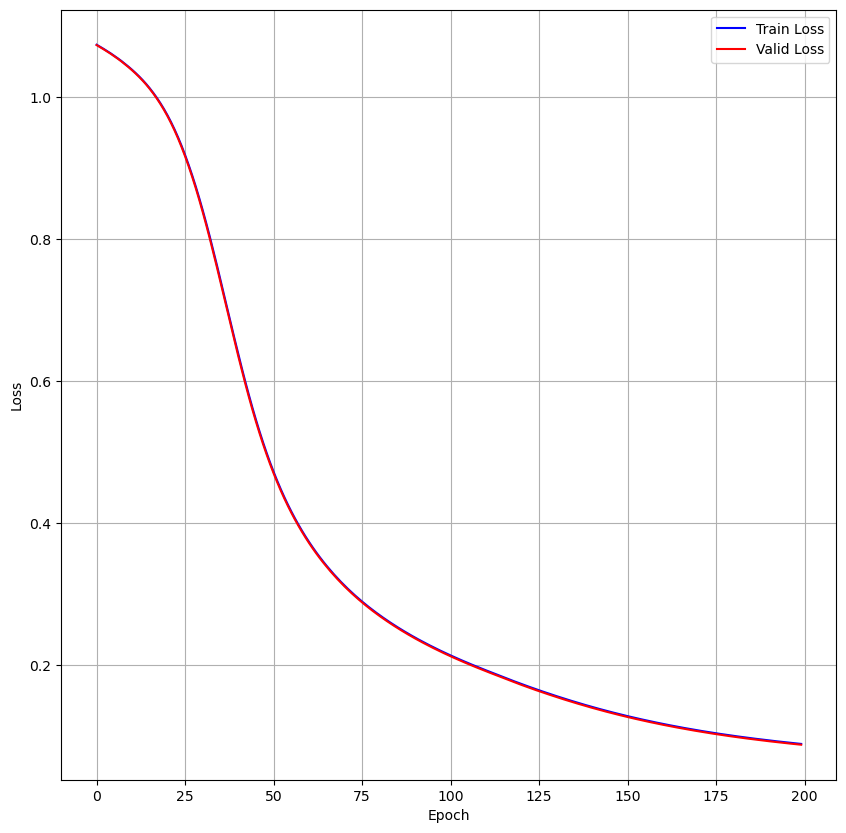

In [175]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(num_epochs), loss_train_hist, color='blue', label='Train Loss')
ax.plot(range(num_epochs), loss_valid_hist, color='red', label='Valid Loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.legend()

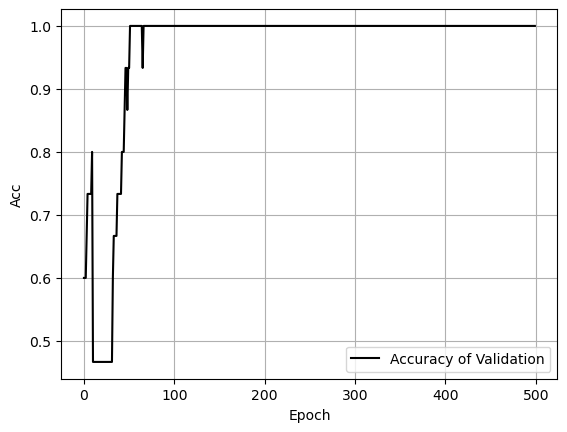

In [34]:
plt.plot(range(num_epochs), acc_valid_hist, color='black', label='Accuracy of Validation')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

# Model Saving

In [35]:
torch.save(clf, 'classification_iris.pth')

In [36]:
torch.load('classification_iris.pth')

C:\Users\Darab Store\AppData\Local\Temp\ipykernel_17484\4041440426.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('classification_iris.pth')


Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=3, bias=True)
)